In [1]:
adj_list = {}

#with open("/results/output_dir/KATNAL2_48_48_1_24.gfa") as f:
with open("/results/output_dir/SNTG2_48_48_1_24.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "L":
            continue
        n1, o1 = int(r[1]),r[2]
        n2, o2 = int(r[3]),r[4]
        o1 = 0 if o1 == "+" else 1
        o2 = 0 if o2 == "+" else 1
        weight = int(r[6].split(":")[-1])
        adj_list.setdefault( n1, [] )
        adj_list[ n1 ]. append((n2, weight))
        adj_list.setdefault( n2, [] )
        adj_list[ n2 ]. append((n1, weight))
        

In [2]:
import networkx as nx

In [3]:
G = nx.DiGraph()
for v, ws in adj_list.items():
    for w, weight in ws:
        G.add_edge(v, w, weight=weight)

In [4]:
node2id=dict([(_[1],_[0]) for _ in enumerate(sorted(list(G.nodes())))])

In [5]:
import numpy as np

In [6]:
adj_matrix = np.zeros( (len(node2id), len(node2id)), dtype=np.float32 )

In [7]:
n_node = len(adj_matrix)

In [8]:
xx = []
yy = []
for v, ws in adj_list.items():
    for w, weight in ws:
        idx0 = node2id[v]
        idx1 = node2id[w]
        assert(weight > 0)
        adj_matrix[idx0][idx1] = weight
     
        xx.append(idx0)
        yy.append(idx1)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

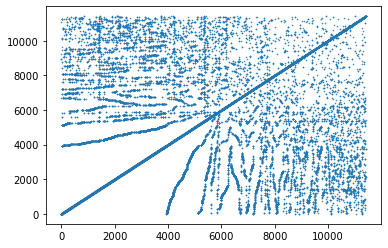

In [10]:
plt.plot(xx, yy, ".", markersize=1)
#plt.xlim(0,10)
#plt.ylim(0,10)

(0.0, 120.0)

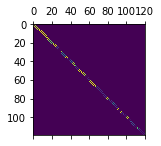

In [11]:
plt.matshow(adj_matrix[0:120,:])
plt.xlim(0,120)

In [12]:
one = np.ones(adj_matrix.shape[0], dtype=np.float32)/n_node
print(np.sum(one))
#one = np.zeros(adj_matrix.shape[0], dtype=np.float32)    
#one[1] = 1

1.0000001


In [13]:
adj_matrix2 = adj_matrix / np.sum(adj_matrix, axis=1)

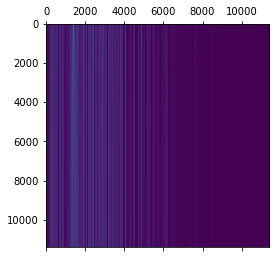

In [14]:

y2 = []
one = np.ones(adj_matrix.shape[0], dtype=np.float32)/n_node
yy = one.copy()
y2.append(yy)

for i in range(n_node):
    #mm = np.matmul(mm, adj_matrix)
    yy = np.inner(adj_matrix2, yy)
    y2.append(yy)
    #print(sum(yy))
    
y2 = np.array(y2)
plt.matshow(y2)
#plt.xlim(0,100)

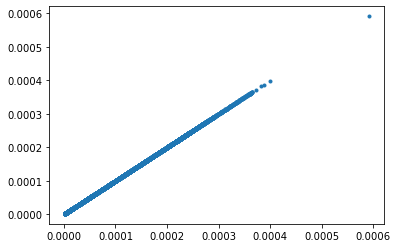

In [15]:
#yy = one.copy()

plt.plot(y2[n_node-2],y2[n_node-1],".")


Text(0.5, 1.0, 'The diffusion distribution vector for SNTG2')

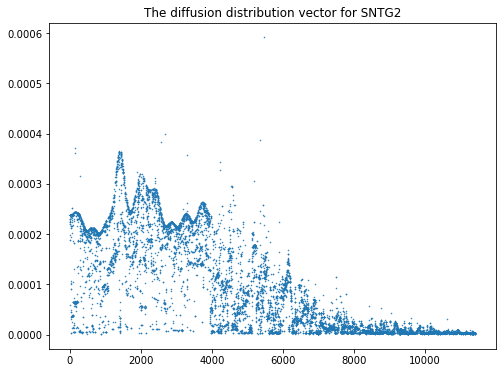

In [16]:
plt.figure(figsize=(8,6))
plt.plot(y2[n_node-1], ".", markersize = 1)
plt.title("The diffusion distribution vector for SNTG2")
#plt.plot((0,len(yy)),(1,1))

In [17]:
np.sum(yy)

0.9999907

In [18]:
np.sum(-yy * np.log2(yy))

12.601763

In [19]:
import pgrtk

In [20]:
pgrtk.__version__

'pgrtk 0.3.3 (main:d256c5f, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [21]:
entropy, weight_list = pgrtk.compute_graph_diffusion_entropy("/results/output_dir/SHANK3_48_48_1_24.gfa")

In [22]:
print(entropy)

9.984265


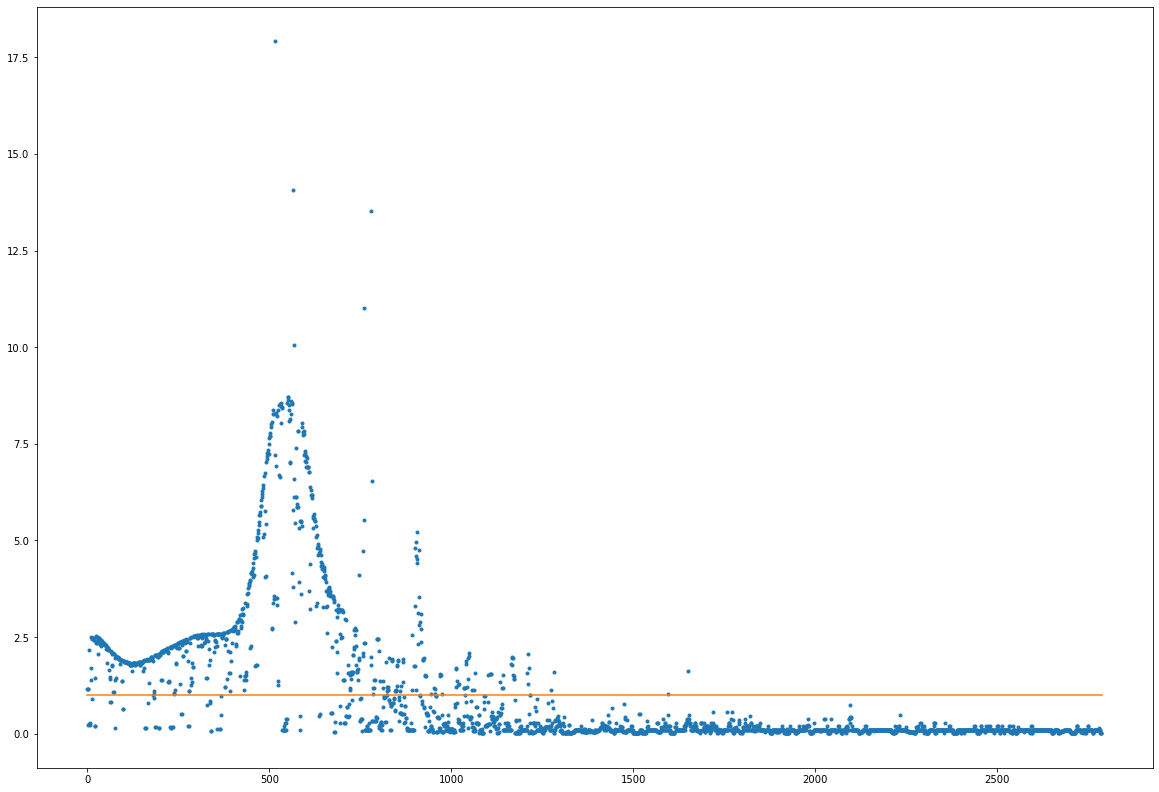

In [23]:
plt.figure(figsize=(20, 14))
x, y = zip(*weight_list)
plt.plot(x, y, ".")
plt.plot((0,len(x)),(1,1))

In [24]:
import glob

In [25]:
gene_not_in_CMRG = set()
with open("/code/gene_not_cmrg_benchmark.txt") as f:
    for r in f:
        r = r.strip()
        gene_not_in_CMRG.add(r)

In [ ]:
x = []
y = []
x2 = []
y2 = []
out = []
for gfa_fn in glob.glob("/results/output_dir/*.gfa"):
    r = pgrtk.compute_graph_diffusion_entropy(gfa_fn,15000)
    if r != None:
        entropy, w = r
        w = [_[1] for _ in w]
        w.sort()
        w = np.mean(w[-32:])
        #print(gfa_fn, entropy, w)
        
        
        n = gfa_fn.split("/")[3].split("_")[0]
        if n in gene_not_in_CMRG:
            x2.append(entropy)
            y2.append(w)
        else:
            x.append(entropy)
            y.append(w)
        count = 0
        with open(gfa_fn) as f:
            for r in f:
                r = r.strip().split()
                if r[0] == "S":
                    count +=1
      
        out.append( (gfa_fn, entropy, w, count) )

In [ ]:
plt.figure(figsize=(8,8))

plt.plot(y2, x2, "ob", markersize=8,   alpha=0.5)
plt.plot(y, x, "og", markersize=6,  alpha=0.5)
plt.legend(["Not In Benchmark", "In Benchmark"])
plt.ylabel("MAP Graph Diffusion Entropy")
plt.xlabel("Max Local Repeat Node Weight")
plt.ylim(7.5, 13)
for gfa_fn, e, w, count in out:
    n = gfa_fn.split("/")[3].split("_")[0]
    if n not in gene_not_in_CMRG:
        continue
    if w > 5 or e > 11:        
        plt.text(w, e, n,fontsize=10)
        
    #if w <= 7 and e > 10.5:
    #    plt.text(w, e, n, fontsize=10)
        
    #if w >= 5 and e > 8:
    #    plt.text(w, e, n, fontsize=10)
    #    print(n, w, e)
plt.savefig('/results/graph_stats_plot.pdf', format='pdf')

In [ ]:
!grep ">" /results/output_dir/out_seqs_with_padding.fa  | tr -d ">" | awk -F "_" '{print $1}' | uniq -c  | awk '{print $2" "$1}' > /results/match_count.txt

In [ ]:
match_count = {}
with open("/results/match_count.txt") as f:
    for r in f:
        r = r.strip().split()
        n, c = r
        c = int(c)
        match_count[n] = c

In [ ]:
f = open("/code/GRCh38_CMRG_MAPgraph_stats.tsv", "w")
print("gene", "entropy", "repetitiveness", "vertex count", "number_contig_count", "in_benchmark", file=f, sep="\t")
for gfa_fn, e, w, count in out:
    n = gfa_fn.split("/")[3].split("_")[0]
    if n in gene_not_in_CMRG:
        in_benchmark = "N"
    else:
        in_benchmark = "Y"
    print(n, e, w, count, match_count[n], in_benchmark, file=f, sep="\t")
f.close()